In [2]:
!wget https://github.com/huseinzol05/Malaya-Dataset/raw/master/news-30k/news-30k.json.zip
!unzip news-30k.json.zip

--2019-09-11 06:26:39--  https://github.com/huseinzol05/Malaya-Dataset/raw/master/news-30k/news-30k.json.zip
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/huseinzol05/Malaya-Dataset/master/news-30k/news-30k.json.zip [following]
--2019-09-11 06:26:39--  https://raw.githubusercontent.com/huseinzol05/Malaya-Dataset/master/news-30k/news-30k.json.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21671789 (21M) [application/zip]
Saving to: ‘news-30k.json.zip.1’

news-30k.json.zip.1 100%[===================>]  20.67M   138MB/s    in 0.2s    

2019-09-11 06:26:40 (138 MB/s) - ‘news-30k.json.zip.1’ sa

In [0]:
import json

with open('news-30k.json') as fopen:
  news = json.load(fopen)

In [0]:
news = news[:50]

texts = [n['text'] for n in news]

In [0]:
import re

def cleaning(string):
  string = re.sub('[^A-Za-z ]+', ' ', string.lower())
  string = re.sub(r'[ ]+', ' ', string).strip()
  return string

In [0]:
for i in range(len(texts)):
  texts[i] = cleaning(texts[i])

In [7]:
combined_texts = ' '.join(texts).split()
vocab = list(set(combined_texts))

len(combined_texts)

10829

In [0]:
def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data)), dtype = np.int32)
    for i in range(len(data)):
        onehot[i] = vocab.index(data[i])
    return onehot

In [0]:
text_vocab = vocab
text = combined_texts

In [0]:
learning_rate = 0.001
batch_size = 16
sequence_length = 32
epoch = 500
num_layers = 2
size_layer = 256
possible_batch_id = range(len(texts) - sequence_length - 1)

class Model:
    def __init__(
        self, num_layers, size_layer, dimension, sequence_length, learning_rate
    ):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(
                size_layer, sequence_length, state_is_tuple = False
            )

        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell() for _ in range(num_layers)], state_is_tuple = False
        )
        self.X = tf.placeholder(tf.int32, (None, None))
        self.Y = tf.placeholder(tf.int32, (None, None))
        
        embeddings = tf.Variable(
            tf.random_uniform([len(text_vocab), size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(embeddings, self.X)
        
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            self.rnn_cells,
            encoder_embedded,
            initial_state = self.hidden_layer,
            dtype = tf.float32,
        )
        
        self.logits = tf.layers.dense(self.outputs, dimension)
        
        logits_long = tf.reshape(self.logits, [-1, dimension])
        y_batch_long = tf.reshape(self.Y, [-1])
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = logits_long, labels = y_batch_long
            )
        )
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        self.correct_pred = tf.equal(
            tf.argmax(logits_long, 1), tf.cast(y_batch_long, tf.int64)
        )
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        self.final_outputs = tf.nn.softmax(self.logits)

In [11]:
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), sequence_length, learning_rate)
sess.run(tf.global_variables_initializer())

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.


In [12]:
from tqdm import tqdm
import time
import numpy as np
import random

def train_random_sequence():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length))
        batch_y = np.zeros((batch_size, sequence_length))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = embed_to_onehot([text[k + n] for k in batch_id],text_vocab)
            id2 = embed_to_onehot([text[k + n + 1] for k in batch_id],text_vocab)
            batch_x[:,n] = id1
            batch_y[:,n] = id2
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

LOST, ACCURACY = train_random_sequence()


epoch: 100%|██████████| 500/500 [04:11<00:00,  2.04it/s, accuracy=1, cost=0.0221]


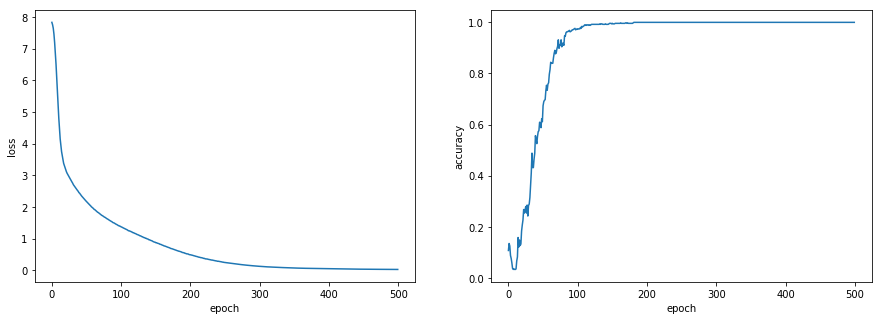

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [14]:
split_text = text
selected_index = np.random.randint(0, len(split_text) - 5)
tag = split_text[selected_index:selected_index + 5]
print(tag)

['shah', 'alam', 'yang', 'di', 'pertuan']


In [15]:
def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag[:]
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[i]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            char = np.argmax(prob[0][0])
        else:
            char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = [text_vocab[char]]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[0]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return ' '.join(sentence_generated)

print(generate_based_sequence(100,False))

shah alam yang di pertuan di di christchurch new zealand pada mac lepas melahirkan rasa terharu akan sokongan diberi rakyat malaysia semasa perhimpunan solidariti kedamaian zarina shuib ibu saudara muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai dalam malaysia dalam malaysia solidariti kedamaian zarina shuib muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian zarina shuib muhammad muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai berkesempatan menyertai rakyat malaysia dalam rakyat perhimpunan solidariti kedamaian zarina shuib ibu saudara muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian


In [19]:
split_text = text
selected_index = np.random.randint(0, len(split_text) - 5)
tag = split_text[selected_index:selected_index + 5]
print(tag)

['bangladesh', 'diserang', 'sakit', 'jantung', 'dan']


In [20]:
def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag[:]
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[i]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            char = np.argmax(prob[0][0])
        else:
            char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = [text_vocab[char]]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[0]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return ' '.join(sentence_generated)

print(generate_based_sequence(100,False))

bangladesh diserang sakit jantung dan dalam tragedi tembakan di christchurch new zealand pada mac lepas melahirkan rasa terharu akan sokongan diberi rakyat malaysia semasa perhimpunan solidariti kedamaian zarina shuib ibu saudara muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai dalam rakyat malaysia semasa perhimpunan solidariti kedamaian ibu saudara muhammad haziq memanjatkan kesyukuran kepada swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian zarina ibu saudara muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti shuib ibu saudara muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian shuib ibu saudara


In [25]:
tag = ['shah', 'alam', 'yang', 'di', 'pertuan']

def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag[:]
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[i]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            char = np.argmax(prob[0][0])
        else:
            char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = [text_vocab[char]]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[0]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return ' '.join(sentence_generated)

print(generate_based_sequence(100,False))

shah alam yang di pertuan christchurch zealand pada mac lepas melahirkan rasa terharu akan sokongan diberi rakyat malaysia semasa perhimpunan solidariti kedamaian zarina shuib ibu saudara muhammad haziq memanjatkan kesyukuran kepada allah swt swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian zarina shuib ibu muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian zarina shuib ibu haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian ibu saudara muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian zarina shuib ibu muhammad haziq memanjatkan kesyukuran


In [28]:
tag = ['apa', 'dia', 'rasa']

def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag[:]
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[i]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            char = np.argmax(prob[0][0])
        else:
            char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = [text_vocab[char]]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[0]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return ' '.join(sentence_generated)

print(generate_based_sequence(100,False))

apa dia rasa dalam tragedi tembakan di christchurch new zealand pada mac lepas melahirkan rasa terharu akan sokongan diberi rakyat malaysia semasa perhimpunan solidariti kedamaian zarina shuib ibu saudara muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian shuib ibu saudara muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat perhimpunan malaysia dalam perhimpunan zarina zarina ibu muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan solidariti kedamaian zarina shuib ibu muhammad haziq memanjatkan kesyukuran kepada allah swt kerana berkesempatan menyertai rakyat malaysia dalam perhimpunan shuib shuib ibu saudara
